<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


    
# 30_BasicLinearRegression

#### Demonstrate linear regression, Lasso regularization for feature selection, and posterior predictive checks

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    + [Prepare Dataset](#Prepare-Dataset)


+ [Basic Linear Regression with StatsModels](#Basic-Linear-Regression-with-StatsModels)


+ [Basic Linear Regression with PyMC3](#Basic-Linear-Regression-with-PyMC3)
    + [Define and Run Model](#Define-and-run-model)
    + [View Feature Coefficients](#View-feature-coefficients)
    + [View Traceplots](#View-Traceplots)
    + [View Autocorrelation Plots](#View-Autocorrelation-Plots)


+ [Basic Linear Regression with PyStan](#Basic-Linear-Regression-with-PyStan)



---

# Setup

In [41]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
# general packages
import sqlite3
from convenience_functions import *
from ipywidgets import interactive, fixed

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize
#from scipy.stats import norm, laplace, ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

## Local Functions

In [3]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


def trace_median(x):
    return pd.Series(np.median(x,0), name='median')


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4)
        ,lines={k: v['mean'] for k, v in 
            pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')    

        
def plot_stan_trc(dftrc):
    """
       Create simple plots of parameter distributions and traces from 
       output of pystan sampling. Emulates pymc traceplots.
    """

    fig, ax2d = plt.subplots(nrows=dftrc.shape[1], ncols=2, figsize=(14, 1.8*dftrc.shape[1]),
                                facecolor='0.99', edgecolor='k')
    fig.suptitle('Distributions and traceplots for {} samples'.format(
                                dftrc.shape[0]),fontsize=14)
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    k = 0
    
    # create density and traceplot, per parameter coeff
    for i, (ax1d, col) in enumerate(zip(ax2d, dftrc.columns)):

        samples = dftrc[col].values
        scale = (10**np.round(np.log10(samples.max() - samples.min()))) / 20
        kde = KernelDensity(bandwidth=scale).fit(samples.reshape(-1, 1))
        x = np.linspace(samples.min(), samples.max(), 100).reshape(-1, 1)
        y = np.exp(kde.score_samples(x))
        clr = sns.color_palette()[0]

        # density plot
        ax1d[0].plot(x, y, color=clr, linewidth=1.4)
        ax1d[0].vlines(np.percentile(samples, [2.5, 97.5]), ymin=0, ymax=y.max()*1.1,
                       alpha=1, linestyles='dotted', colors=clr, linewidth=1.2)
        mn = np.mean(samples)
        ax1d[0].vlines(mn, ymin=0, ymax=y.max()*1.1,
                       alpha=1, colors='r', linewidth=1.2)
        ax1d[0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')    
        ax1d[0].set_title('{}'.format(col), fontdict={'fontsize':10})


        # traceplot
        ax1d[1].plot(np.arange(len(samples)),samples, alpha=0.2, color=clr, linestyle='solid'
                              ,marker=',', markerfacecolor=clr, markersize=10)
        ax1d[1].hlines(np.percentile(samples,[2.5, 97.5]), xmin=0, xmax=len(samples),
                       alpha=1, linestyles='dotted', colors=clr)
        ax1d[1].hlines(np.mean(samples), xmin=0, xmax=len(samples), alpha=1, colors='r')

        k += 1
                
        ax1d[0].set_title('{}'.format(col), fontdict={'fontsize':14})#,'fontweight':'bold'})
        #ax1d[0].legend(loc='best', shadow=True)
        
        _ = [ax1d[j].axes.grid(True, linestyle='-', color='lightgrey') for j in range(2)]
            
    plt.subplots_adjust(top=0.94)
    plt.show()

## Load Data

In [4]:
cnxsql = sqlite3.connect('data/car_emissions.db')
df = pd.read_sql('select * from cars', cnxsql, index_col=None)

In [5]:
## convert sqlite bool storage (as ints) back to bools
for ft in ['parent_is_vw','mfr_is_vw','is_tdi']:
    df[ft] = df[ft].astype(bool)

In [6]:
custom_describe(df)

(2646, 18)


,2607,1653,835,count,mean,std,min,25%,50%,75%,max,dtype
mfr,volvo,mercedes-benz,bmw,2646,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
model,"v60, my16","c-class saloon, model year 2015",7 series f01/f02,2646,NaN,NaN,1 seri,NaN,NaN,NaN,zafira,object
desc,d4,"c 220 bluetec with 18"" rear wheels",730d saloon,2646,NaN,NaN,'1 air,NaN,NaN,NaN,zc 1.6,object
fuel_type,diesel,diesel,diesel,2646,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
metric_combined,4.4,4.1,5.6,2646,5.65,1.87,3.1,4.4,5.1,6.30,16,float64
metric_extra_urban,3.9,3.6,5.1,2646,4.85,2.35,0,4.0,4.5,5.30,107,float64
metric_urban_cold,5.3,4.9,6.5,2646,7.10,3.00,0,5.2,6.2,8.10,24.7,float64
engine_capacity,1969,2143,2993,2646,2072.58,903.62,395,1560.0,1984.0,1999.00,6752,float64
emissions_co_mgkm,203,278,223,2646,268.34,140.71,30,162.0,243.0,341.75,913,float64
emissions_nox_mgkm,19,62,46,2646,37.38,18.63,1,23.0,35.0,52.00,158,float64


## Prepare Dataset

This dataset allows us to ask if there's any interesting patterns in NOx emissions: for cars made by the Volkswagen group

+ `emissions_nox_mgkm`

... according to a handful of exogenous variables:

+ `mfr_owner_is_vw, transmission, fuel_type_smpl, is_tdi`
+ `engine_capacity, metric_combined, metric_extra_urban, metric_urban_cold`


##### Declare feats for use

In [7]:
fts_cat = ['parent_is_vw', 'mfr_is_vw', 'parent', 'mfr', 'trans', 'fuel_type', 'is_tdi']
fts_cat_smp = ['mfr_is_vw','trans','fuel_type','is_tdi']
fts_num = ['metric_combined', 'metric_extra_urban', 'metric_urban_cold'
           ,'engine_capacity', 'emissions_co_mgkm']
fts_num_smp = ['metric_combined', 'engine_capacity', 'emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

### Apply exclusions 
To make analysis a little easier:
1. remove extreme outliers in the endogenous feat (cheating)
2. Remove hybrids

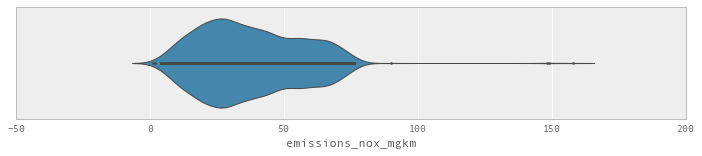

In [8]:
f, ax1d = plt.subplots(1,1,figsize=(12,2))
_ = sns.violinplot(x=ft_endog, data=df, ax=ax1d, inner='point')

In [9]:
df.loc[df[ft_endog]>80]

,mfr,model,desc,fuel_type,metric_combined,metric_extra_urban,metric_urban_cold,engine_capacity,emissions_co_mgkm,emissions_nox_mgkm,particulates_no_mgkm,thc_nox_emissions_mgkm,thc_emissions_mgkm,trans,is_tdi,parent,mfr_is_vw,parent_is_vw
1744,mercedes-benz,"e-class estate, model year 2015",e 250 with 17'' rear wheels,petrol,5.5,5.0,6.2,1991.0,287.0,90.0,NaN,NaN,62.0,auto,False,daimler-ag,False,False
1751,mercedes-benz,"e-class estate, model year 2016",e 220 bluetec with 18'' & 19'' rear wheels,diesel,5.5,4.8,6.5,2143.0,94.0,148.0,0.2,160.0,NaN,auto,False,daimler-ag,False,False
1752,mercedes-benz,"e-class estate, model year 2016",e 350 bluetec with 18'' & 19'' rear wheels eco...,diesel,4.4,4.4,4.3,2987.0,248.0,158.0,0.2,181.0,NaN,auto,False,daimler-ag,False,False
2056,peugeot,308 cc,1.6 e-hdi 115,diesel,4.8,4.4,5.5,1560.0,216.0,149.0,0.4,184.0,NaN,manual,False,peugeot-citroen,False,False


In [10]:
df = df.loc[(df[ft_endog]<=80) & (df['fuel_type'] != 'hybrid')].copy()
df.shape

(2593, 18)

##### Standardize the dataset according to Gelman 1 / (2 * sd)

Divide by 2 standard deviations in order to put the variance of a normally distributed variable nearer to the variance range of a binary variable. See http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf for more info.

In [11]:
dfs = pd.concat((df[ft_endog], df[fts_cat]
    ,((df[fts_num] - df[fts_num].mean(0)) / (2 * df[fts_num].std(0)))),1)
custom_describe(dfs)

(2593, 13)


,765,1771,1039,count,mean,std,min,25%,50%,75%,max,dtype
emissions_nox_mgkm,32,56,27,2593,37.32,17.9,1,23.000000,35.000000,51.000000,76,float64
parent_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
mfr_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
parent,bmw,daimler-ag,peugeot-citroen,2593,NaN,NaN,aston,NaN,NaN,NaN,volksw,object
mfr,bmw,mercedes-benz,citroen,2593,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
trans,auto,auto,manual,2593,NaN,NaN,auto,NaN,NaN,NaN,semiau,object
fuel_type,petrol,diesel,diesel,2593,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
is_tdi,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
metric_combined,0.220426,-0.31275,-0.472703,2593,-0.00,0.5,-0.685973,-0.339409,-0.152797,0.167108,2.75301,float64
metric_extra_urban,0.0728415,-0.159767,-0.286644,2593,0.00,0.5,-0.47696,-0.180913,-0.075182,0.093988,21.5997,float64


##### Write to DB for later use

In [12]:
dfs.reset_index(inplace=True)
del dfs['index']
dfs.to_sql('cars_post_exclusions_2sd', cnxsql, if_exists='replace', index=None)
cnxsql.close()

## Describe dataset

+ The dataset is 2593 rows, with 12 exog features, 1 endog feature.
+ These are observations of car emissions tests, one row per car.
+ You can read off the basic distributional statistics of the features in the table above. Numeric features have been standardized according to [Gelman's 2sd principle](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
+ I have selected these particular 12 features to work with. Some are derivatives of original features.

We have the following features to choose from:

```
+ Categoricals:
    + `trans`     - the car transmission, simplified to 'auto', 'semiauto', 'manual'
    + `fuel_type` - the car power supply, simplified to 'petrol', 'diesel'
    + `parent`    - the parent company of the car manufacturer, 20 values
    + `mfr`       - the car manufacturer, 38 values

+ Booleans:
    + `parent_is_vw` - if the parent company of the car manufacturer is Volkswagen
    + `mfr_is_vw`    - if the car manufacturer is Volkswagen
    + `is_tdi`       - (processed feature) if the car engine type is a turbo diesel
    
+ Numerics:
    + `metric_combined`    - a score for fuel efficiency in combined driving
    + `metric_extra_urban` - a score for fuel efficiency in an extra-urban driving
    + `metric_urban_cold`  - a score for fuel efficiency in an urban setting, cold start
    + `emissions_co_mgkm`  - a count of CO particulates emitted mg/km
    
+ Numeric endogenous feature:
    + `emissions_nox_mgkm` - a count of NOx particulates emitted mg/km    
```

For the purposes of this Notebook, the final feature mentioned `emissions_nox_mgkm` will be used as the _endogenous_ / _dependent_ / _output_ feature of the linear models. All other features may be used as _exogenous_ / _independent_ / _input_ features.

---

---

# Basic Linear Regression with StatsModels

First we'll create an intentionally basic OLS (Ordinary Least Squares) Regression model, to warm up to using PyMC3 and PyStan with real data.


$$\bf{y} \sim \mathcal{N}(\beta^{T} \bf{x},\sigma^{2})$$

<p style="font-size:small;">
... where for datapoint $i \in n$:
<br>$y_{i}$ is a sample from a $\mathcal{N}$ormal distribution defined by
mean $\mu = \beta^{T} x_{i}$ and variance $\sigma^{2}$
</p>


#### Declare full modelspec

In [13]:
fml_all = '{} ~ '.format(ft_endog) + ' + '.join(fts_num_smp + fts_cat_smp)
fml_all

'emissions_nox_mgkm ~ metric_combined + engine_capacity + emissions_co_mgkm + mfr_is_vw + trans + fuel_type + is_tdi'

##### Create design matrices for statsmodels

In [14]:
(mx_en, mx_ex) = pt.dmatrices(fml_all, dfs, return_type='dataframe', NA_action='raise')
custom_describe(mx_ex, 2, )

(2593, 9)


,277,1778,count,mean,std,min,25%,50%,75%,max,dtype
Intercept,1.000000,1.000000,2593,1.00,0.00,1.000000,1.000000,1.000000,1.000000,1.000000,float64
mfr_is_vw[T.True],0.000000,0.000000,2593,0.04,0.20,0.000000,0.000000,0.000000,0.000000,1.000000,float64
trans[T.manual],0.000000,0.000000,2593,0.49,0.50,0.000000,0.000000,0.000000,1.000000,1.000000,float64
trans[T.semiauto],1.000000,0.000000,2593,0.12,0.32,0.000000,0.000000,0.000000,0.000000,1.000000,float64
fuel_type[T.petrol],0.000000,0.000000,2593,0.50,0.50,0.000000,0.000000,1.000000,1.000000,1.000000,float64
is_tdi[T.True],1.000000,0.000000,2593,0.12,0.32,0.000000,0.000000,0.000000,0.000000,1.000000,float64
metric_combined,-0.232774,-0.046162,2593,-0.00,0.50,-0.685973,-0.339409,-0.152797,0.167108,2.753013,float64
engine_capacity,0.495609,0.506617,2593,0.00,0.50,-0.920116,-0.278857,-0.045471,-0.037765,2.579014,float64
emissions_co_mgkm,-0.347058,0.513762,2593,0.00,0.50,-0.846545,-0.382482,-0.088458,0.272874,2.281452,float64


## Frequentist OLS Regression

For later comparison, first let's use `statsmodels` to run a Freqentist OLS

In [15]:
smfit_ols = sm.OLS(mx_en, mx_ex).fit()
print(smfit_ols.summary())

                            OLS Regression Results                            
Dep. Variable:     emissions_nox_mgkm   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     306.4
Date:                Mon, 25 Apr 2016   Prob (F-statistic):               0.00
Time:                        12:20:07   Log-Likelihood:                -10295.
No. Observations:                2593   AIC:                         2.061e+04
Df Residuals:                    2584   BIC:                         2.066e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              46.1078    

**Observe**

+ That was easy! `statsmodels` is great for basic stuff
+ The R-squared of ~0.48 isn't too bad considering the possible range (-inf,1) (NOTE I explain a little more about r-squared theory later on)
+ The condition number of 9.83 below 20, the [recommended theshold](http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html) at which we should consider the effects of multicollinearity

I won't get into the actual interpretation of the coefficient values yet.


**NOTE** 

+ Just in case you missed it, I used `patsy` above to create 'design matrices' for the data, prior to modelling with `statsmodels`. This converted the main dataframe to the same 'modelspec' as I will use throughout the Frequentist and Bayesian modelling.
+ The categorical features have been binarised (a.k.a one-hot encoded) and the `Intercept` coefficient is overloaded with the first value from each categorical feature to allow for proper _identifiability_: i.e:
    + if a datapoint had raw feature value `trans == manual`, that is now indicated by a boolean `True` in the new column `trans[T.manual]`, and a boolean `False` in the new column `trans[T.semiauto]`
    + if a datapoint had raw feature value `trans == auto`, that is now indicated by a boolean `False` in the new columns `trans[T.manual]` and `trans[T.semiauto]`: the `Intercept` column always has value `1` aka `True`, meaning that `trans == auto` is represented by the `Intercept`.
    + The overloading means that the `Intercept` represents cars with categorical values `trans == auto`, `mfr_owner_is_vw == False`, `fuel_type == diesel`, and `is_tdi == False`.
+ Due to our _standardization_ (mean-centering and dividing by the std.dev.) the `Intercept` also represents the mean of the numeric features.

## Frequentist Ridge Regression

Actually, since it's trivial to do so, lets run an L2-regularized 'Ridge' Regression

In [16]:
smfit_ridge = sm.OLS(mx_en, mx_ex).fit_regularized(alpha=1, L1_wt=0)  # set L1_wt=1 for Lasso
smfit_ridge.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     emissions_nox_mgkm   R-squared:                      -0.812
Model:                            OLS   Adj. R-squared:                 -0.818
Method:                 Least Squares   F-statistic:                    -144.8
Date:                Mon, 25 Apr 2016   Prob (F-statistic):               1.00
Time:                        12:20:09   Log-Likelihood:                -11930.
No. Observations:                2593   AIC:                         2.388e+04
Df Residuals:                    2584   BIC:                         2.393e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              16.1647      1.172     13.790      0.000        13.866    18.463
mfr_is_vw[T.True]       0.7789      2.507      0.311      0.756        -4.138     5.696
trans[T.manual]         6.3385      1.131      5.605      0.000         4.121     8.556
trans[T.semiauto]       2.1810      1.770      1.232      0.218        -1.290     5.652
fuel_type[T.petrol]     2.3057      1.683      1.370      0.171        -0.994     5.606
is_tdi[T.True]          3.5658      1.826      1.953      0.051        -0.015     7.146
metric_combined        -2.1764      2.623     -0.830      0.407        -7.319     2.966
engine_capacity         1.1804      2.252      0.524      0.600        -3.236     5.597
emissions_co_mgkm      -2.2916      1.121     -2.044      0.041        -4.490    -0.093
==============================================================================
Omnibus:                      322.722   Durbin-Watson:                   0.519
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.472
Skew:                           0.287   Prob(JB):                     8.42e-26
Kurtosis:                       2.140   Cond. No.                         9.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

---

# Basic Linear Regression with PyMC3

First, lets look at a few different basic linear regression models

## v1: build model (OLS, full syntax)

In [17]:
with pm.Model() as mdl_ols_longwinded:
    
    # define priors, use Uniform for OLS
    b0 = pm.Uniform('b0_intercept', lower=-1e3, upper=1e3)
    b1a = pm.Uniform('b1a_trans[T.manual]', lower=-1e3, upper=1e3)
    b1b = pm.Uniform('b1b_trans[T.semiauto]', lower=-1e3, upper=1e3)
    b2 = pm.Uniform('b2_fuel_type[T.petrol]', lower=-1e3, upper=1e3)
    b3 = pm.Uniform('b3_is_tdi[T.True]', lower=-1e3, upper=1e3)
    b4 = pm.Uniform('b4_mfr_is_vw[T.True]', lower=-1e3, upper=1e3)
    b5 = pm.Uniform('b5_engine_capacity', lower=-1e3, upper=1e3)
    b6 = pm.Uniform('b6_metric_combined', lower=-1e3, upper=1e3)
    b7 = pm.Uniform('b7_emissions_co_mgkm', lower=-1e3, upper=1e3)
    
    # define linear model
    yest = ( b0 +
             b1a * mx_ex['trans[T.manual]'] +
             b1b * mx_ex['trans[T.semiauto]'] +
             b2 * mx_ex['fuel_type[T.petrol]'] + 
             b3 * mx_ex['is_tdi[T.True]'] +
             b4 * mx_ex['mfr_is_vw[T.True]'] +
             b5 * mx_ex['engine_capacity'] +
             b6 * mx_ex['metric_combined'] +
             b7 * mx_ex['emissions_co_mgkm']) 

    ## Define Normal likelihood with HalfNormal error
    epsilon = pm.HalfCauchy('epsilon', 10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=epsilon, observed=mx_en[ft_endog])
    

Applied interval-transform to b0_intercept and added transformed b0_intercept_interval to model.
Applied interval-transform to b1a_trans[T.manual] and added transformed b1a_trans[T.manual]_interval to model.
Applied interval-transform to b1b_trans[T.semiauto] and added transformed b1b_trans[T.semiauto]_interval to model.
Applied interval-transform to b2_fuel_type[T.petrol] and added transformed b2_fuel_type[T.petrol]_interval to model.
Applied interval-transform to b3_is_tdi[T.True] and added transformed b3_is_tdi[T.True]_interval to model.
Applied interval-transform to b4_mfr_is_vw[T.True] and added transformed b4_mfr_is_vw[T.True]_interval to model.
Applied interval-transform to b5_engine_capacity and added transformed b5_engine_capacity_interval to model.
Applied interval-transform to b6_metric_combined and added transformed b6_metric_combined_interval to model.
Applied interval-transform to b7_emissions_co_mgkm and added transformed b7_emissions_co_mgkm_interval to model.
Applied l

## v2: build model (OLS, using glm submodule)

+ syntactic sugar!
+ Force betas to Uniform (for OLS)
+ Likelihood is Normal (with default HalfCauchy for error prior)

In [18]:
with pm.Model() as mdl_ols:
      
    pm.glm.glm(fml_all,
               dfs,
               intercept_prior=pm.Uniform.dist(lower=-1e3, upper=1e3),
               regressor_prior=pm.Uniform.dist(lower=-1e3, upper=1e3),
               family=pm.glm.families.Normal())

Applied interval-transform to Intercept and added transformed Intercept_interval to model.
Applied interval-transform to mfr_is_vw[T.True] and added transformed mfr_is_vw[T.True]_interval to model.
Applied interval-transform to trans[T.manual] and added transformed trans[T.manual]_interval to model.
Applied interval-transform to trans[T.semiauto] and added transformed trans[T.semiauto]_interval to model.
Applied interval-transform to fuel_type[T.petrol] and added transformed fuel_type[T.petrol]_interval to model.
Applied interval-transform to is_tdi[T.True] and added transformed is_tdi[T.True]_interval to model.
Applied interval-transform to metric_combined and added transformed metric_combined_interval to model.
Applied interval-transform to engine_capacity and added transformed engine_capacity_interval to model.
Applied interval-transform to emissions_co_mgkm and added transformed emissions_co_mgkm_interval to model.
Applied log-transform to sd and added transformed sd_log to model.


## v3: build model (Ridge Regression, glm default settings)

+ Normal priors and likelihood

In [19]:
with pm.Model() as mdl_ridge:
      
    pm.glm.glm(fml_all, dfs)

Applied log-transform to sd and added transformed sd_log to model.


Recap OLS:


$$\bf{y} \sim \mathcal{N}(\beta^{T} \bf{x},\sigma^{2})$$

<p style="font-size:small;">
... where for datapoint $i \in n$:
<br>$y_{i}$ is a sample from a $\mathcal{N}$ormal distribution defined by
mean $\mu = \beta^{T} x_{i}$ and variance $\sigma^{2}$
</p>

$$\sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)x_{i}^{T} = 0$$

$$\beta_{MLE} = (X^{T}X)^{-1}X^{T}y$$


##### Ridge (L2 regularisation)

Add new parameter $\lambda$ to constrain the sum of squared values of $\beta$

$$\beta_{MLE} = \overset{argmin}{\beta} = \frac{1}{2} \; \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2} + \lambda \sum_{i=1}^{n} \left(\beta_{i} \right)^{2}$$

Possible to create closed form:

$$\beta_{MLE} = (\lambda I + X^{T}X)^{-1}X^{T}y$$

## Note: I've skipped right over Lasso

I blogged about it earlier in the year: http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/

##### Lasso (L1 regularization)

Or more generally, we would solve using a numerical optimization, allowing for complicated MLE fitting including penalties on the cost function.


Set parameter $\lambda$ to constrain the sum of absolute values of \beta

$$\beta_{MLE} = \overset{argmin}{\beta} = \frac{1}{2} \; \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2} + \lambda \sum_{i=1}^{n} \left|\beta_{i} \right|$$

Solutions are non-linear in $y_{i}$ so there's no closed form

## v4: build model (Robust Regression, glm using StudentT likelihood)

+ Normal priors (so Ridge Regression L2 reg)
+ StudentT likelihood

In [20]:
with pm.Model() as mdl_robust:
      
    pm.glm.glm(fml_all,
               dfs,
               family=pm.glm.families.StudentT())

Applied log-transform to lam and added transformed lam_log to model.


## Okay, lets get on with it and use v4

##### Take samples using NUTS (recording to file for later usage)

In [40]:
with mdl_robust:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)

    ## take samples
    trc_robust = pm.sample(2000, start=start_MAP, njobs=1, step=pm.NUTS()
                        ,trace=pm.backends.Text('traces/trc_robust_pymc'))


 [-----------------100%-----------------] 2000 of 2000 complete in 33.7 sec

##### Dump model to disk

Note open issue: https://github.com/pymc-devs/pymc3/issues/895

In [22]:
write_pickle(obj=mdl_robust, relnm='models/mdl_robust_pymc.pkl')

'Serialized object to disk at models/mdl_robust_pymc.pkl'

##### View traceplots (full trace)

Rather than just get point-estimate statistics from the traces, let's take a look at the traceplots using PyMC3's built-in `pm.traceplot()` function.

+ each feature coefficient is shown on a single row
+ the right-hand-side plot is a simple timeseries of each value on the trace over selected samples
+ the left-hand-side plot is a density plot of the traces (mean shown in red) this is a marginal posterior distribution on each coefficient

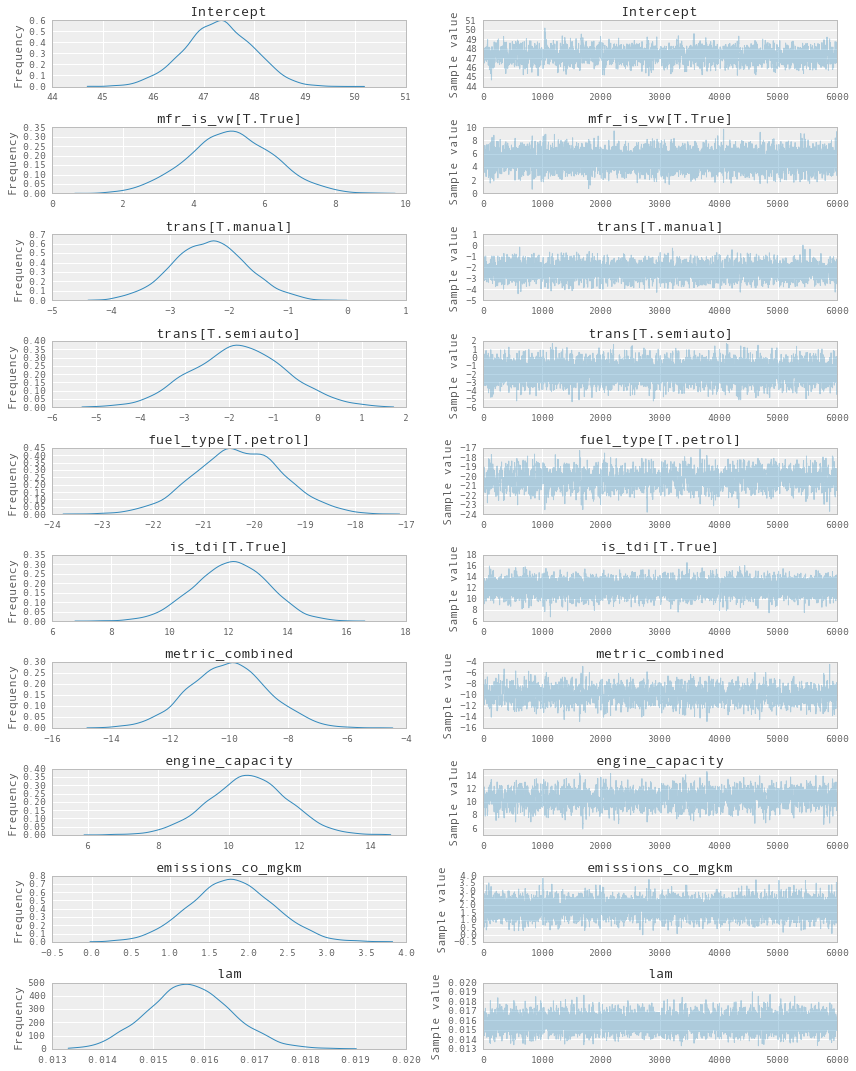

In [23]:
rvs_robust = [rv.name for rv in strip_derived_rvs(mdl_robust.unobserved_RVs)]
_ = pm.traceplot(trc_robust[:], varnames=rvs_robust, figsize=(12, len(rvs_robust)*1.5))

##### View traceplots (post burnin)

/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


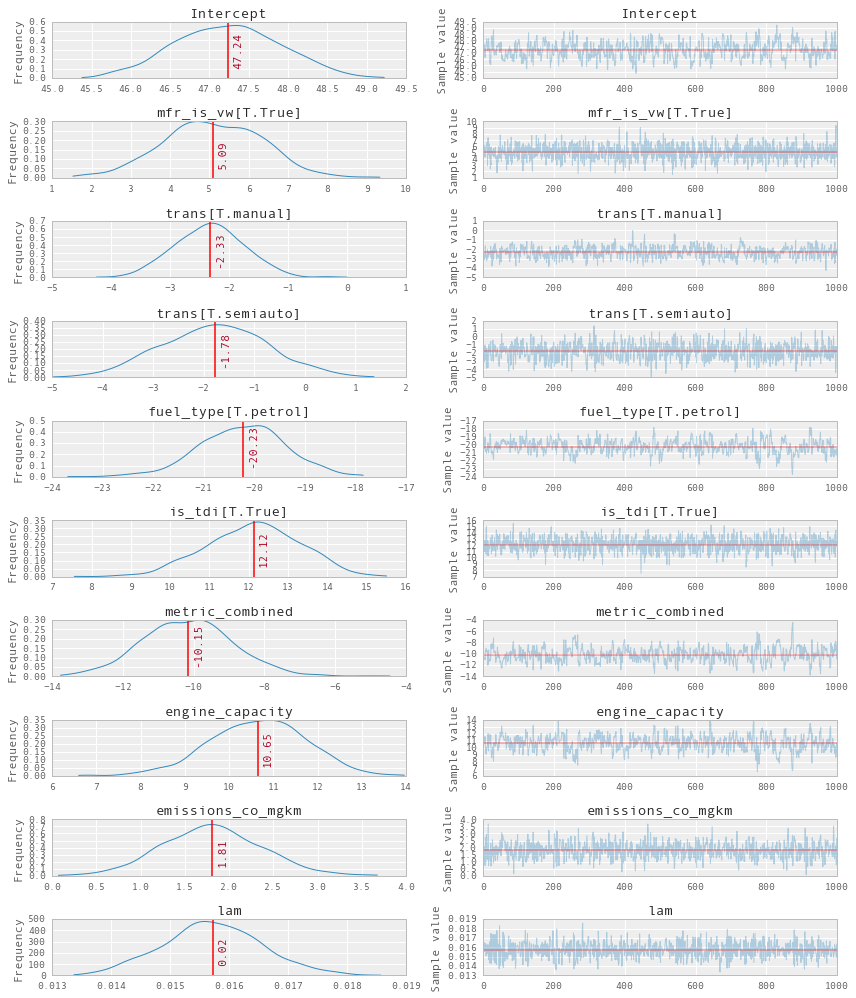

In [24]:
plot_traces_pymc(trc_robust[-1000:], varnames=rvs_robust)

##### View feature coefficients

**Observe**

+ Most of the co-efficients have a bell-shaped curve for the marginal posterior distribution (particularly the Intercept for example), this indicates:
    + the coefficients have settled to a single value in a symmetirc distribution with some variance
    + the coefficients do not display multi-modalities which would indicate we have mis-specified the model
    + we could perhaps try a new model using bell-shaped priors for each of the coefficients and get better performance: a Gaussian with large variance would probably be a good place to start.
+ Similarly, most of the timeseries traceplots show a 'hairy caterpillar' form, where all values, both inlying and extreme, occur frequently but at irregular intervals throughout the trace. This indicates the markov sampler chain was 'well-mixed', taking samples evenly from the area surrounding the optimal position


##### View coeffs in a table

In [25]:
print(pm.df_summary(trc_robust[-1000:], varnames=rvs_robust))

                          mean        sd  mc_error    hpd_2.5   hpd_97.5
Intercept            47.237479  0.660831  0.038801  45.933271  48.468864
mfr_is_vw[T.True]     5.085837  1.245759  0.038649   2.677581   7.371912
trans[T.manual]      -2.325049  0.593578  0.028069  -3.498169  -1.258951
trans[T.semiauto]    -1.781626  1.031597  0.039417  -3.835769   0.138719
fuel_type[T.petrol] -20.227540  0.862772  0.051753 -21.841356 -18.521136
is_tdi[T.True]       12.122484  1.178836  0.037109   9.956361  14.299307
metric_combined     -10.150041  1.296009  0.077135 -12.540997  -7.496150
engine_capacity      10.650850  1.103634  0.063010   8.363456  12.631013
emissions_co_mgkm     1.808891  0.560817  0.020104   0.644862   2.808978
lam                   0.015723  0.000835  0.000023   0.014000   0.017250


/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


**Observe:**
    
+ The above table summarises the final 1000 steps of the traces, giving us the basic statistics of the distributions of the parameter estimates.
+ You can see the mean values are very similar to the `statsmodels` OLS model, which is good to see, and for reference they shown in the following cell:

### View Autocorrelation Plots

Following from our observations above, lets look at the _autocorrelation_ of the traces 

i.e. at timestep $t$, is the position of the trace correlated with _it's own_ lagged position at a previous timestep $t-n$, for $n \in [t,0]$

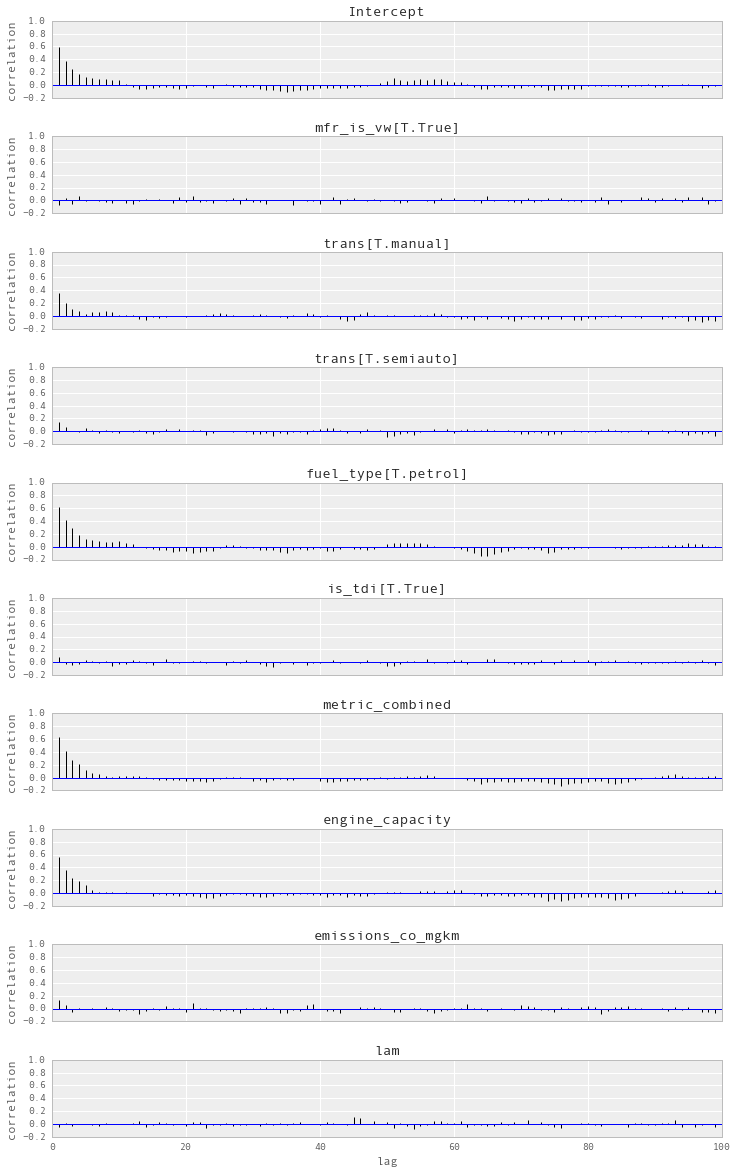

In [26]:
ax = pm.autocorrplot(trc_robust[-1000:], varnames=rvs_robust)

---

---

# Basic Linear Regression with PyStan

##### Define input dictionary

In [27]:
stan_datadict = {}
stan_datadict['N'] = mx_ex.shape[0]
stan_datadict['K'] = mx_ex.shape[1]
stan_datadict['X'] = mx_ex.values
stan_datadict['y'] = mx_en[ft_endog].values

##### Define Model

In [28]:
mdl_robust_stan_spec = """

    /* Spec for robust regression linear model */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        vector[N] y;                        // endog feature
    }
    parameters {
        vector[K] beta;                     // exog coeffs
        real<lower=0> sigma;                // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);              // explicit prior for error (half-cauchy)
        y ~ student_t(1, X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
    """

##### Compile model and sample all-in-one

In [29]:
mdl_robust_stan_fit = pystan.stan(
        model_code  = mdl_robust_stan_spec,
        data        = stan_datadict,
        sample_file = ensure_dir('traces/trc_robust_stan/chain'),
        model_name  = 'mdl_robust_stan',
        iter        = 1000,
        warmup      = 750, 
        chains      = 4, 
        n_jobs      = 2, 
        verbose     = False)

##### Example verbose output


    Compiling /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/stanfit4mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9_3944964805647522407.pyx because it changed.
    [1/1] Cythonizing /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/stanfit4mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9_3944964805647522407.pyx
    building 'stanfit4mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9_3944964805647522407' extension
    C compiler: gcc -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/jon/anaconda/envs/pymc3_vs_pystan/include -arch x86_64

    creating /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var
    creating /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var/folders
    creating /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var/folders/xy
    creating /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn
    creating /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T
    creating /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt
    compile options: '-DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DEIGEN_NO_DEBUG -I/var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt -I/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/pystan -I/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/pystan/stan/src -I/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/pystan/stan/lib/stan_math -I/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.2.4 -I/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/pystan/stan/lib/stan_math/lib/boost_1.58.0 -I/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/include -I/Users/jon/anaconda/envs/pymc3_vs_pystan/include/python3.5m -c'
    extra options: '-O2 -ftemplate-depth-256 -Wno-unused-function -Wno-uninitialized'
    gcc: /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/stanfit4mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9_3944964805647522407.cpp
    g++ -bundle -undefined dynamic_lookup -L/Users/jon/anaconda/envs/pymc3_vs_pystan/lib -arch x86_64 /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/stanfit4mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9_3944964805647522407.o -L/Users/jon/anaconda/envs/pymc3_vs_pystan/lib -o /var/folders/xy/_prdxwd9431_kp0lx7ngmfbc0000gn/T/tmpa4ifr6pt/stanfit4mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9_3944964805647522407.cpython-35m-darwin.so

##### Dump model to disk

In [30]:
# get model obj from fit obj
mdl_robust_stan_model = mdl_robust_stan_fit.get_stanmodel()
write_pickle(obj=mdl_robust_stan_model, relnm='models/mdl_robust_stan_model.pkl')

'Serialized object to disk at models/mdl_robust_stan_model.pkl'

##### Dump fitted model to disk

In [31]:
write_pickle(mdl_robust_stan_fit, 'models/mdl_robust_stan_fit.pkl')

/Users/jon/Documents/workspace/personal/pymc3_vs_pystan/convenience_functions.py:17: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, protocol=-1)


'Serialized object to disk at models/mdl_robust_stan_fit.pkl'

##### View summary results

In [32]:
print(mdl_robust_stan_fit)

Inference for Stan model: mdl_robust_stan_51509fed66fb388a5ca2b659b774e0a9.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  47.32    0.05    0.7  45.93  46.84  47.31  47.77  48.68    178    1.0
beta[1]   5.08    0.07   1.28   2.55   4.28   5.09   5.94   7.65    319    1.0
beta[2]  -2.36    0.04   0.65  -3.69  -2.77  -2.36  -1.93  -0.99    270    1.0
beta[3]  -1.85    0.07   1.14  -4.18  -2.59  -1.85  -1.14   0.54    269    1.0
beta[4] -20.33    0.08   0.86 -22.15 -20.92  -20.3 -19.71 -18.71    127   1.01
beta[5]  12.12    0.07   1.25   9.69  11.25  12.13  13.04  14.47    283    1.0
beta[6]  -9.96     0.1   1.33  -12.4 -10.83  -9.98  -9.15  -7.24    193   1.01
beta[7]  10.48    0.09   1.14    8.1   9.76  10.48  11.29  12.59    170   1.01
beta[8]   1.79    0.03   0.58   0.65   1.39   1.78   2.17   2.97    290    1.0
sigma     7.99    

##### View basic plot

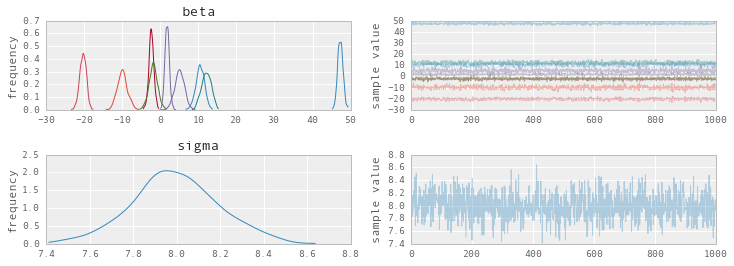

In [33]:
mdl_robust_stan_fit.plot()
plt.show()

##### Convenience: we can even view the stan code from the fit object

In [34]:
print(mdl_robust_stan_fit.get_stancode())



    /* Spec for robust regression linear model */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        vector[N] y;                        // endog feature
    }
    parameters {
        vector[K] beta;                     // exog coeffs
        real<lower=0> sigma;                // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);              // explicit prior for error (half-cauchy)
        y ~ student_t(1, X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
    


##### In fact, the fit object contains all samples for further use

In [35]:
# return a dictionary of arrays
samples = mdl_robust_stan_fit.extract(permuted=True)
for k, v in samples.items():
    print(k, v.shape)

beta (1000, 9)
sigma (1000,)
lp__ (1000,)


In [36]:
# return a 3d array (samples, chains, coeffs)
samples = mdl_robust_stan_fit.extract(permuted=False) 
print(samples.shape)

(250, 4, 11)


##### So we can save to a dataframe

In [37]:
dftrc_robust_stan = pd.DataFrame(samples.reshape(1000,11),
                               columns=mx_ex.columns.tolist() + ['sigma', '_lp'])

In [38]:
dftrc_robust_stan.head()

,Intercept,mfr_is_vw[T.True],trans[T.manual],trans[T.semiauto],fuel_type[T.petrol],is_tdi[T.True],metric_combined,engine_capacity,emissions_co_mgkm,sigma,_lp
0,47.423725,5.872053,-3.946311,-4.583178,-19.783669,14.469397,-10.465470,10.286204,1.067606,7.914866,-7859.307142
1,47.090041,5.015027,-2.769715,-1.454244,-20.136282,12.566171,-10.674340,11.002314,2.044257,8.092264,-7851.734856
2,47.560509,4.757169,-2.453002,-1.212243,-20.554742,12.548799,-10.676288,10.636188,2.847383,8.108098,-7853.277239
3,47.043098,5.419678,-2.726723,-1.647602,-19.958500,11.858331,-11.369548,12.307868,1.818783,8.314161,-7854.832822
4,47.919774,6.681245,-3.605249,-3.925745,-20.683816,12.578425,-10.663810,10.887118,2.550341,7.965247,-7855.612280


##### And emulate the PyMC3 plotting

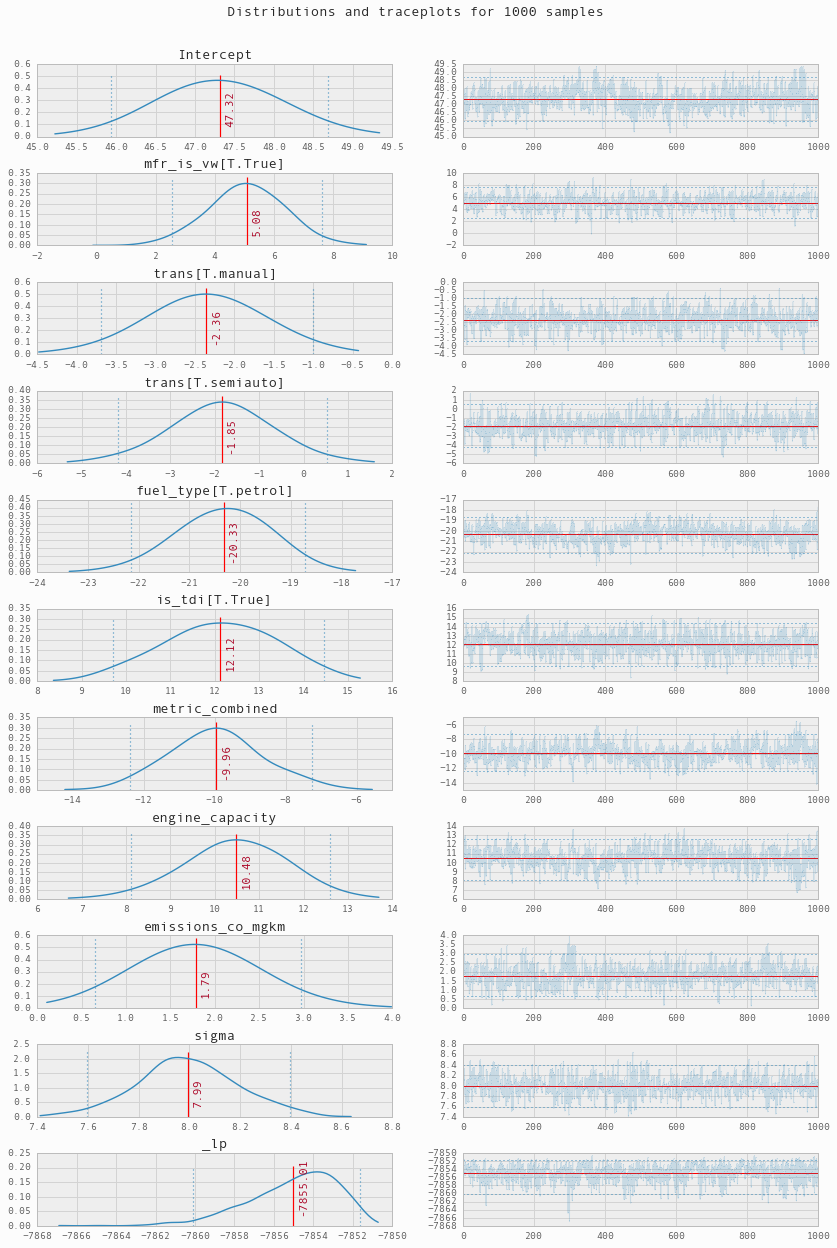

In [39]:
plot_stan_trc(dftrc_robust_stan)

> Hurray! The results are nearly identical

---

---

### For more examples of robust regression and outlier detection

Outlier detection: using e.g. exotic mixed likelihood functions and more degrees of freedom to identify particular datapoints as outliers.

I've submitted another notebook to the PyMC3 examples folder, showing [robust regession and outlier detection](http://pymc-devs.github.io/pymc3/GLM-robust-with-outlier-detection/)


### What else can we easily do with these packages?

Model evaluation / selection

I've submitted a notebook to the PyMC3 examples folder, showing [model evaluation and polynomial regression](http://pymc-devs.github.io/pymc3/GLM-model-selection/)

> In fact, lets take a look at that now, since it's important...

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>